In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

In [47]:
# # Specify the path to your pickle file
# file_path = "../../../dataset/cri_compustat_merged_v8.pkl"

# # Open the pickle file for reading
# with open(file_path, 'rb') as file:
#     # Load the data from the pickle file
#     df_full = pickle.load(file)

In [48]:
from google.oauth2 import service_account
import pandas_gbq as gbq 
import json
from pandas_gbq import to_gbq, read_gbq

credentials_path = '../../../token.json'

# Authenticate with your credentials
credentials = service_account.Credentials.from_service_account_file(
    credentials_path, scopes=['https://www.googleapis.com/auth/bigquery'])

# Set the credentials for pandas_gbq
gbq.context.credentials = credentials

In [49]:
# import dataframe from GBQ

df_full = read_gbq(f"""

SELECT *
FROM capstone-402105.capstone.cri_compustat_data

""",project_id='capstone-402105', dialect='standard')

Downloading: 100%|██████████|


In [54]:
df_full.columns

Index(['CompNo', 'year', 'month', 'StkIndx', 'STInt', 'dtdlevel', 'dtdtrend',
       'liqnonfinlevel', 'liqnonfintrend', 'ni2talevel', 'ni2tatrend',
       'sizelevel', 'sizetrend', 'm2b', 'sigma', 'liqfinlevel', 'lqfintrend',
       'DTDmedianFin', 'DTDmedianNonFin', 'dummy297fin', 'StartDate',
       'EventDate', 'Default_1', 'Default_3', 'Default_6', 'Default_12',
       'Default_24', 'Default_36', 'Default_60', 'Duration', 'gvkey', 'tic',
       'current_ratio', 'quick_ratio', 'cash_ratio', 'net_working_capital',
       'debt_ratio', 'debt_to_equity_ratio', 'equity_ratio',
       'cashflow_to_debt_ratio', 'net_profit_margin', 'return_on_assets',
       'asset_turnover', 'inventory_turnover', 'days_in_inventory',
       'receivables_turnover', 'day_sales_outstanding',
       'working_capital_turnover', 'price_to_earnings',
       'dividend_payout_ratio', 'retention_ratio', 'gross_margin_ratio',
       'operating_profit_margin', 'ebitda_margin',
       'debt_service_coverage_ratio', 

In [129]:
# Taking a subsample of the dataset as the dataset is too large for the model to run
subsample_default_0 = df_full[df_full['Default_12'] == 0].sample(frac=0.8)
subsample_default_1 = df_full[df_full['Default_12'] == 1]
df = pd.concat([subsample_default_0, subsample_default_1])
df = df.sample(frac=1)

In [130]:
import datetime
import pytz

df.sort_values(by='EventDate', inplace=True)

#Split data into train, validation and test 
date2022 = datetime.datetime(2022, 1, 1).replace(tzinfo=pytz.UTC)
date2020 = datetime.datetime(2020,1,1).replace(tzinfo=pytz.UTC)
train_df = df[df["EventDate"] < date2020]
val_df = df[(df["EventDate"] >= date2020) & (df["EventDate"] < date2022)]
test_df = df[df["EventDate"] >= date2022]

In [131]:
df.describe()

,CompNo,year,month,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,...,day_sales_outstanding,working_capital_turnover,price_to_earnings,dividend_payout_ratio,retention_ratio,gross_margin_ratio,operating_profit_margin,ebitda_margin,debt_service_coverage_ratio,interest_coverage_ratio
count,945401.0,945401.000000,945401.0,945401.000000,945401.000000,945401.000000,945401.000000,945401.000000,945401.000000,945401.000000,...,9.454010e+05,945401.000000,945401.000000,945401.000000,945401.000000,9.454010e+05,9.454010e+05,9.454010e+05,945401.000000,945401.000000
mean,39266.736071,2009.192581,6.494882,0.052631,-0.003969,4.179124,-0.035315,0.655978,-0.013351,-0.004552,...,-2.057151e+04,1.025486,57.903479,0.225606,-1.660093,-5.427160e+04,-8.787088e+05,-8.641539e+05,-22060.619315,-18583.325444
std,11419.571418,6.406697,3.421997,0.179004,0.007663,2.983536,1.225145,0.833014,0.292015,0.037018,...,1.931384e+06,329.338703,411.023150,3.264028,53.214726,5.295777e+05,4.295241e+06,4.256695e+06,52889.249783,72087.686496
min,22043.0,2000.000000,1.0,-0.545579,-0.012097,-1.113511,-35.341088,-4.156714,-2.559415,-1.324832,...,-2.711250e+07,-64030.374242,-66666.666667,-747.736000,-1149.000000,-5.251700e+06,-2.189250e+07,-2.185540e+07,-149041.103448,-297211.000000
25%,30442.0,2004.000000,4.0,-0.054010,-0.010955,2.155986,-0.608525,0.000000,-0.084461,-0.003499,...,0.000000e+00,0.011506,-11.000000,0.000000,0.800000,1.942027e+01,-7.853107e+01,-7.354810e+01,-3.966571,0.249084
50%,37353.0,2008.000000,6.0,0.083647,-0.006739,3.626075,-0.015447,0.543828,0.000000,0.001745,...,1.035426e+02,0.569644,43.173913,0.000000,1.000000,3.540365e+01,-5.435879e+01,-4.825457e+01,-0.613060,4.152709
75%,46072.0,2014.000000,9.0,0.148992,0.001362,5.590752,0.573893,1.115853,0.064313,0.005540,...,2.432905e+02,1.450795,89.644737,0.200000,1.000000,5.466943e+01,-2.561359e+01,-1.500697e+01,-0.096300,13.009506
max,127028.0,2023.000000,12.0,0.713380,0.013861,114.654533,14.933724,4.787727,2.683886,0.216094,...,9.736054e+08,109677.200000,41375.000000,765.000000,748.736000,8.017000e+05,1.603300e+06,1.582700e+06,5576.666667,132673.500000


In [132]:
print(df.shape)

(945401, 56)


c:\Users\Melissa\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
c:\Users\Melissa\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),
c:\Users\Melissa\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
c:\Users\Melissa\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:500: FutureWarning: In a future ve

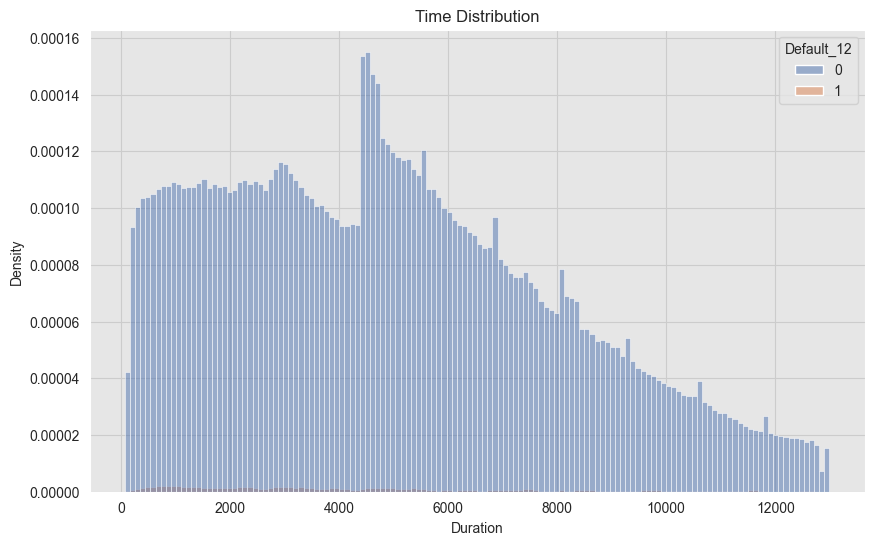

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure and axis
fig, ax = plt.subplots()

# Create the histogram with the 'EventType' hue
sns.histplot(data=df, x='Duration', hue='Default_12', stat='density', ax=ax)

# Set the title
ax.set_title('Time Distribution')

# Show the plot
plt.show()


c:\Users\Melissa\AppData\Local\Programs\Python\Python310\lib\site-packages\lifelines\utils\__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


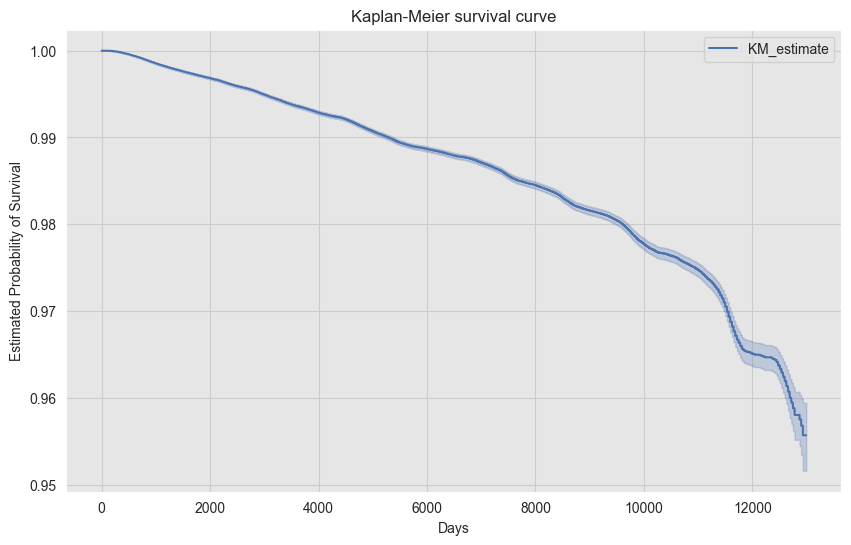

In [134]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()

kmf.fit(durations=df['Duration'], event_observed=df['Default_12'])

fig, ax =  plt.subplots()
kmf.plot_survival_function(color='C0',ax=ax)
ax.set(
    title='Kaplan-Meier survival curve',
    xlabel='Days',
    ylabel='Estimated Probability of Survival'
);

In [135]:
# make a correlation matrix
correlation_matrix = df.corr()

# Print pairs of features with correlations above 0.9
threshold = 0.9
correlation_pairs = []
for col1 in correlation_matrix.columns:
    for col2 in correlation_matrix.columns:
        if col1 != col2 and abs(correlation_matrix.loc[col1, col2]) > threshold:
            correlation_pairs.append((col1, col2, correlation_matrix.loc[col1, col2]))

if correlation_pairs:
    print("Correlations above 0.9:")
    for col1, col2, corr in correlation_pairs:
        print(f"Columns {col1} and {col2} have a correlation of {corr}")
else:
    print("No correlations above 0.9 found.")


C:\Users\Melissa\AppData\Local\Temp\ipykernel_23196\1049231920.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


Correlations above 0.9:
Columns liqfinlevel and dummy297fin have a correlation of -0.9022272807810447
Columns DTDmedianFin and dummy297fin have a correlation of 0.9158423200684516
Columns dummy297fin and liqfinlevel have a correlation of -0.9022272807810447
Columns dummy297fin and DTDmedianFin have a correlation of 0.9158423200684516
Columns current_ratio and quick_ratio have a correlation of 0.9999954847337462
Columns quick_ratio and current_ratio have a correlation of 0.9999954847337462
Columns net_profit_margin and operating_profit_margin have a correlation of 0.9620049533236581
Columns net_profit_margin and ebitda_margin have a correlation of 0.943468776886419
Columns operating_profit_margin and net_profit_margin have a correlation of 0.9620049533236581
Columns operating_profit_margin and ebitda_margin have a correlation of 0.9799306789147013
Columns ebitda_margin and net_profit_margin have a correlation of 0.943468776886419
Columns ebitda_margin and operating_profit_margin have a 

In [136]:
#Drop feature that causes high correlation to be able to run model without multicorrelation error
df.drop(["quick_ratio", "operating_profit_margin", "ebitda_margin", "dummy297fin", "DTDmedianNonFin"], axis=1, inplace=True)

In [137]:
#Ensure there are no more highly correlated pairs
correlation_matrix = df.corr()
threshold = 0.9
correlation_pairs = []
for col1 in correlation_matrix.columns:
    for col2 in correlation_matrix.columns:
        if col1 != col2 and abs(correlation_matrix.loc[col1, col2]) > threshold:
            correlation_pairs.append((col1, col2, correlation_matrix.loc[col1, col2]))

if correlation_pairs:
    print("Correlations above 0.9:")
    for col1, col2, corr in correlation_pairs:
        print(f"Columns {col1} and {col2} have a correlation of {corr}")
else:
    print("No correlations above 0.9 found.")

C:\Users\Melissa\AppData\Local\Temp\ipykernel_23196\1354625380.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


No correlations above 0.9 found.


In [138]:
df.drop(["year", "month", "gvkey", "StartDate", "tic", 'Default_1', 'Default_3', 'Default_6',
        'Default_24', 'Default_36', 'Default_60',], axis=1, inplace=True)

In [139]:
import datetime
import pytz

df.sort_values(by='EventDate', inplace=True)

#Split data into train, validation and test 
date2022 = datetime.datetime(2022, 1, 1).replace(tzinfo=pytz.UTC)
date2020 = datetime.datetime(2020,1,1).replace(tzinfo=pytz.UTC)
train_df = df[df["EventDate"] < date2020]
val_df = df[(df["EventDate"] >= date2020) & (df["EventDate"] < date2022)]
test_df = df[df["EventDate"] >= date2022]

In [140]:
test_df.groupby('Default_12')["CompNo"].count()

Default_12
0    29145
1      156
Name: CompNo, dtype: int64

In [173]:
# Get proportion of Defaulted companies in test df
156/(29145+156)

0.005324050373707382

In [142]:
# val_date = datetime(2020, 1, 1)

# val_df = train_df[train_df["date"] >= val_date]
# train_df = train_df[train_df["date"] < val_date]
# print("train_df shape:", train_df.shape)
# print("val_df shape:", val_df.shape)

In [143]:
# Get proportion of Defaulted companies in train df
train_df.groupby("Default_12")["CompNo"].count()

Default_12
0    860579
1      8878
Name: CompNo, dtype: int64

In [174]:
8878/(860579+8878)

0.010210970755310498

In [145]:
# Get proportion of Defaulted companies in validation df
val_df.groupby('Default_12')["CompNo"].count()

Default_12
0    46327
1      316
Name: CompNo, dtype: int64

In [175]:
316/(46327+316)

0.0067748643955148685

In [147]:
print(train_df.columns)


Index(['CompNo', 'StkIndx', 'STInt', 'dtdlevel', 'dtdtrend', 'liqnonfinlevel',
       'liqnonfintrend', 'ni2talevel', 'ni2tatrend', 'sizelevel', 'sizetrend',
       'm2b', 'sigma', 'liqfinlevel', 'lqfintrend', 'DTDmedianFin',
       'EventDate', 'Default_12', 'Duration', 'current_ratio', 'cash_ratio',
       'net_working_capital', 'debt_ratio', 'debt_to_equity_ratio',
       'equity_ratio', 'cashflow_to_debt_ratio', 'net_profit_margin',
       'return_on_assets', 'asset_turnover', 'inventory_turnover',
       'days_in_inventory', 'receivables_turnover', 'day_sales_outstanding',
       'working_capital_turnover', 'price_to_earnings',
       'dividend_payout_ratio', 'retention_ratio', 'gross_margin_ratio',
       'debt_service_coverage_ratio', 'interest_coverage_ratio'],
      dtype='object')


In [148]:
train_df.drop(["CompNo", "EventDate"], axis=1, inplace=True)
val_df.drop(["CompNo", "EventDate"], axis=1, inplace=True)
test_df.drop(["CompNo", "EventDate"], axis=1, inplace=True)

C:\Users\Melissa\AppData\Local\Temp\ipykernel_23196\3097251762.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(["CompNo", "EventDate"], axis=1, inplace=True)
C:\Users\Melissa\AppData\Local\Temp\ipykernel_23196\3097251762.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df.drop(["CompNo", "EventDate"], axis=1, inplace=True)
C:\Users\Melissa\AppData\Local\Temp\ipykernel_23196\3097251762.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

In [150]:
train_X = train_df
train_X.dropna(inplace=True)
val_X = val_df
val_X.dropna(inplace=True)
test_X = test_df
test_X.dropna(inplace=True)

C:\Users\Melissa\AppData\Local\Temp\ipykernel_23196\890013741.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.dropna(inplace=True)
C:\Users\Melissa\AppData\Local\Temp\ipykernel_23196\890013741.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X.dropna(inplace=True)
C:\Users\Melissa\AppData\Local\Temp\ipykernel_23196\890013741.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_X.dropna(inplace=True)


In [151]:
train_X.head()

,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,ni2tatrend,sizelevel,sizetrend,...,days_in_inventory,receivables_turnover,day_sales_outstanding,working_capital_turnover,price_to_earnings,dividend_payout_ratio,retention_ratio,gross_margin_ratio,debt_service_coverage_ratio,interest_coverage_ratio
808993,0.089239,0.011089,2.065252,-0.744829,0.000000,0.000000,0.001183,-0.000119,2.043010,-0.142880,...,1312.400195,0.131266,1509.989956,0.000000,53.125000,0.468750,0.531250,51.539837,-0.032901,3.242347
1176085,0.313050,0.007314,5.571826,-0.542878,1.290709,0.302820,0.000299,0.001229,2.606777,-0.254565,...,6827.763534,2.621167,139.250933,1.339685,-35.661765,0.000000,1.000000,-38.656148,-149041.103448,-297211.000000
518936,0.089239,0.011089,1.435176,0.425093,1.447957,-0.226795,-0.007164,-0.005942,-0.689431,0.288056,...,21903.928617,0.576940,632.648288,0.226389,-6.944444,0.000000,1.000000,21.450151,-0.250017,-3.941953
410949,0.089239,0.011089,4.223675,0.827864,1.563809,-0.122713,-0.058121,0.008451,0.203848,-0.097594,...,3263.234189,1.035765,352.396702,1.204017,-59.375000,0.000000,1.000000,55.518914,-23.321053,-712.666667
1132928,0.089239,0.011089,2.707476,-0.190283,0.000000,0.000000,0.001342,-0.000034,1.189049,-0.182963,...,1312.400195,0.131266,1509.989956,0.327232,55.084746,0.237288,0.762712,51.539837,-0.032901,3.242347


In [153]:
print(train_X.columns)

Index(['StkIndx', 'STInt', 'dtdlevel', 'dtdtrend', 'liqnonfinlevel',
       'liqnonfintrend', 'ni2talevel', 'ni2tatrend', 'sizelevel', 'sizetrend',
       'm2b', 'sigma', 'liqfinlevel', 'lqfintrend', 'DTDmedianFin',
       'Default_12', 'Duration', 'current_ratio', 'cash_ratio',
       'net_working_capital', 'debt_ratio', 'debt_to_equity_ratio',
       'equity_ratio', 'cashflow_to_debt_ratio', 'net_profit_margin',
       'return_on_assets', 'asset_turnover', 'inventory_turnover',
       'days_in_inventory', 'receivables_turnover', 'day_sales_outstanding',
       'working_capital_turnover', 'price_to_earnings',
       'dividend_payout_ratio', 'retention_ratio', 'gross_margin_ratio',
       'debt_service_coverage_ratio', 'interest_coverage_ratio'],
      dtype='object')


In [157]:
# Fit the Cox Proportional-Hazards (CoxPH) model with the selected features
from lifelines import CoxPHFitter
from sklearn.metrics import roc_auc_score, accuracy_score

cph_list = []
train_auc = []
val_auc = []

# cph = CoxPHFitter()
# cph.fit(df_selected_features, duration_col="DaysDuration", event_col="EventType")
# cph.print_summary()   

step_size = [0.01, 0.05, 0.1]
penalizer = [0, 0.1, 0.5, 0.7]
l1_ratio = [0, 1.0]

for s in step_size:
    for p in penalizer:
        for l in l1_ratio:
            if l == 0:
                if p == 0:
                    cph = CoxPHFitter()
                else:
                    cph = CoxPHFitter(penalizer=p)
            else:
                cph = CoxPHFitter(penalizer=p, l1_ratio=l)

            cph.fit(train_X, 'Duration', event_col='Default_12', fit_options={'step_size': s})

            baseline_haz = cph.baseline_hazard_['baseline hazard'][365.0]
            x_pred = np.array(cph.predict_partial_hazard(train_X)) * baseline_haz
            x_pred = np.transpose(x_pred)
            train_auc.append(roc_auc_score(train_X['Default_12'], x_pred))
            val_x_pred = np.array(cph.predict_partial_hazard(val_X)) * baseline_haz
            val_x_pred = np.transpose(val_x_pred)
            val_auc.append(roc_auc_score(val_X['Default_12'], val_x_pred))

            cph_list.append({'cph': cph, 'step_size': s, 'penalizer': p, 'l1_ratio': l})
            

c:\Users\Melissa\AppData\Local\Programs\Python\Python310\lib\site-packages\lifelines\utils\__init__.py:1102: ConvergenceWarning: Column(s) ['STInt'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
c:\Users\Melissa\AppData\Local\Programs\Python\Python310\lib\site-packages\lifelines\fitters\coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 228.439. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in the dataset?

  warnings.warn(
c:\Users\Melissa\AppData\Local\Programs\Python\Python310\lib\site-packages\lifelines\utils\__init__.py:1102: ConvergenceWarning: Column(s) ['STInt'] have very low variance. This may harm convergence. 1) Are you using formula's

In [158]:
# Assuming you have a DataFrame named train_X

# Count how many rows have "Default" equal to 0
count_default_0 = (train_X['Default_12'] == 0).sum()

# Count how many rows have "Default" equal to 1
count_default_1 = (train_X['Default_12'] == 1).sum()

# Print the counts
print("Count of Default == 0:", count_default_0)
print("Count of Default == 1:", count_default_1)


Count of Default == 0: 860579
Count of Default == 1: 8878


In [159]:
m = max(train_auc)
print(m)
[i for i, j in enumerate(train_auc) if j == m]

0.9273774814454756


[16, 17]

In [160]:
m = max(val_auc)
print(m)
[i for i, j in enumerate(val_auc) if j == m]

0.9494152465426701


[16, 17]

In [161]:
cph_list[16]

{'cph': <lifelines.CoxPHFitter: fitted with 869457 total observations, 860579 right-censored observations>,
 'step_size': 0.1,
 'penalizer': 0,
 'l1_ratio': 0}

In [162]:
cph_list[17]

{'cph': <lifelines.CoxPHFitter: fitted with 869457 total observations, 860579 right-censored observations>,
 'step_size': 0.1,
 'penalizer': 0,
 'l1_ratio': 1.0}

In [163]:
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 869457 total observations, 860579 right-censored observations>
             duration col = 'Duration'
                event col = 'Default_12'
                penalizer = 0.7
                 l1 ratio = 1.0
      baseline estimation = breslow
   number of observations = 869457
number of events observed = 8878
   partial log-likelihood = -114141.46
         time fit was run = 2023-11-10 11:03:39 UTC

---
                              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                           
StkIndx                      -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
STInt                         0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
dtdlevel                     -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
dtdtrend                     -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
liqnonfinlevel               -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
liqnonfintrend               -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ni2talevel                   -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ni2tatrend                   -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
sizelevel                    -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
sizetrend                    -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
m2b                          -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
sigma                         0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
liqfinlevel                   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
lqfintrend                    0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
DTDmedianFin                 -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
current_ratio                -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
cash_ratio                    0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
net_working_capital          -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
debt_ratio                    0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
debt_to_equity_ratio          0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
equity_ratio                 -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
cashflow_to_debt_ratio        0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
net_profit_margin            -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
return_on_assets             -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
asset_turnover               -0.00       1.00       0.00            -0.00             0.00         

In [164]:
x_pred = np.array(cph.predict_partial_hazard(train_X)) * baseline_haz
x_pred = np.transpose(x_pred)
x_pred.shape

(869457,)

In [166]:
roc_auc_score(train_df['Default_12'], x_pred)

0.9012879171324614

In [167]:
test_x_pred = np.array(cph.predict_partial_hazard(test_X)) * baseline_haz
test_x_pred = np.transpose(test_x_pred)
test_x_pred.shape

(29301,)

In [169]:
roc_auc_score(test_df['Default_12'], test_x_pred)


0.9363986873765567

In [172]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

# Compute precision and recall values
precision, recall, _ = precision_recall_curve(test_df['Default_12'], test_x_pred)

# Calculate the area under the precision-recall curve (PRAUC)
prauc = auc(recall, precision)

print('PRAUC:', prauc)

ap = average_precision_score(test_df['Default_12'], test_x_pred)
print('average_precision_score', ap)


PRAUC: 0.05392688079254973
average_precision_score 0.05469229482994823
